<a href="https://colab.research.google.com/github/jessicachitkuer/MedicaidRegressionAnalysis/blob/main/Session_5_Showing_Census_Variables_on_a_Map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Census Data

In [ ]:
# @title Setup

!pip install -U -q geopandas folium censusdata folium mapclassify

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import censusdata
import requests
import folium

%config InlineBackend.figure_format = 'retina'

# Change the graph defaults
plt.rcParams['figure.figsize'] = (8, 3)  # Default figure size of 8x3 inches
plt.rcParams['axes.grid'] = False
plt.rcParams['grid.color'] = 'lightgray'
plt.rcParams['font.size'] = 10  # Default font size of 10 points
plt.rcParams['lines.linewidth'] = 1  # Default line width of 1 points
plt.rcParams['lines.markersize'] = 3  # Default marker size of 3 points
plt.rcParams['legend.fontsize'] = 10  # Default legend font size of 10 poin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.4/323.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 13.8 MB/s eta 0:00:00


In [ ]:
# @title Download Tract Shapefile for State and Limit Tracts to County of Interest

# Download the census tracts shapes from US Census
# We download from the TIGER shapefiles repository

STATEFP = "36"  # New York State
COUNTYFP = "061"  # Manhattan
YEAR = 2019

# Download the boundaries of tracts
filename = f"tl_{YEAR}_{STATEFP}_tract.zip"
!mkdir -p maps
!curl  -s https://www2.census.gov/geo/tiger/TIGER$YEAR/TRACT/$filename -o maps/$filename
!cd maps && unzip -o $filename > /dev/null
shapefile = f"maps/{filename[:-4]}.shp"
geo_df = gpd.GeoDataFrame.from_file(shapefile)
# Keep only the data for the county of interest
geo_df = geo_df.query(f"COUNTYFP == '{COUNTYFP}'")

# We download the water areas, to avoid including water areas in our maps
water_filename = f"tl_{YEAR}_{STATEFP+COUNTYFP}_areawater.zip"
!curl -s https://www2.census.gov/geo/tiger/TIGER$YEAR/AREAWATER/$water_filename  -o maps/$water_filename
!cd maps && unzip -o $water_filename  > /dev/null
water_shapefile = f"maps/{water_filename[:-4]}.shp"
water_geodf = gpd.GeoDataFrame.from_file(water_shapefile)

# Remove water areas from the tracts
geo_df = gpd.overlay(geo_df, water_geodf, how="difference")

# Keep only variables of interest
geo_df = geo_df.filter(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAMELSAD', 'ALAND', 'geometry'])

<Axes: >

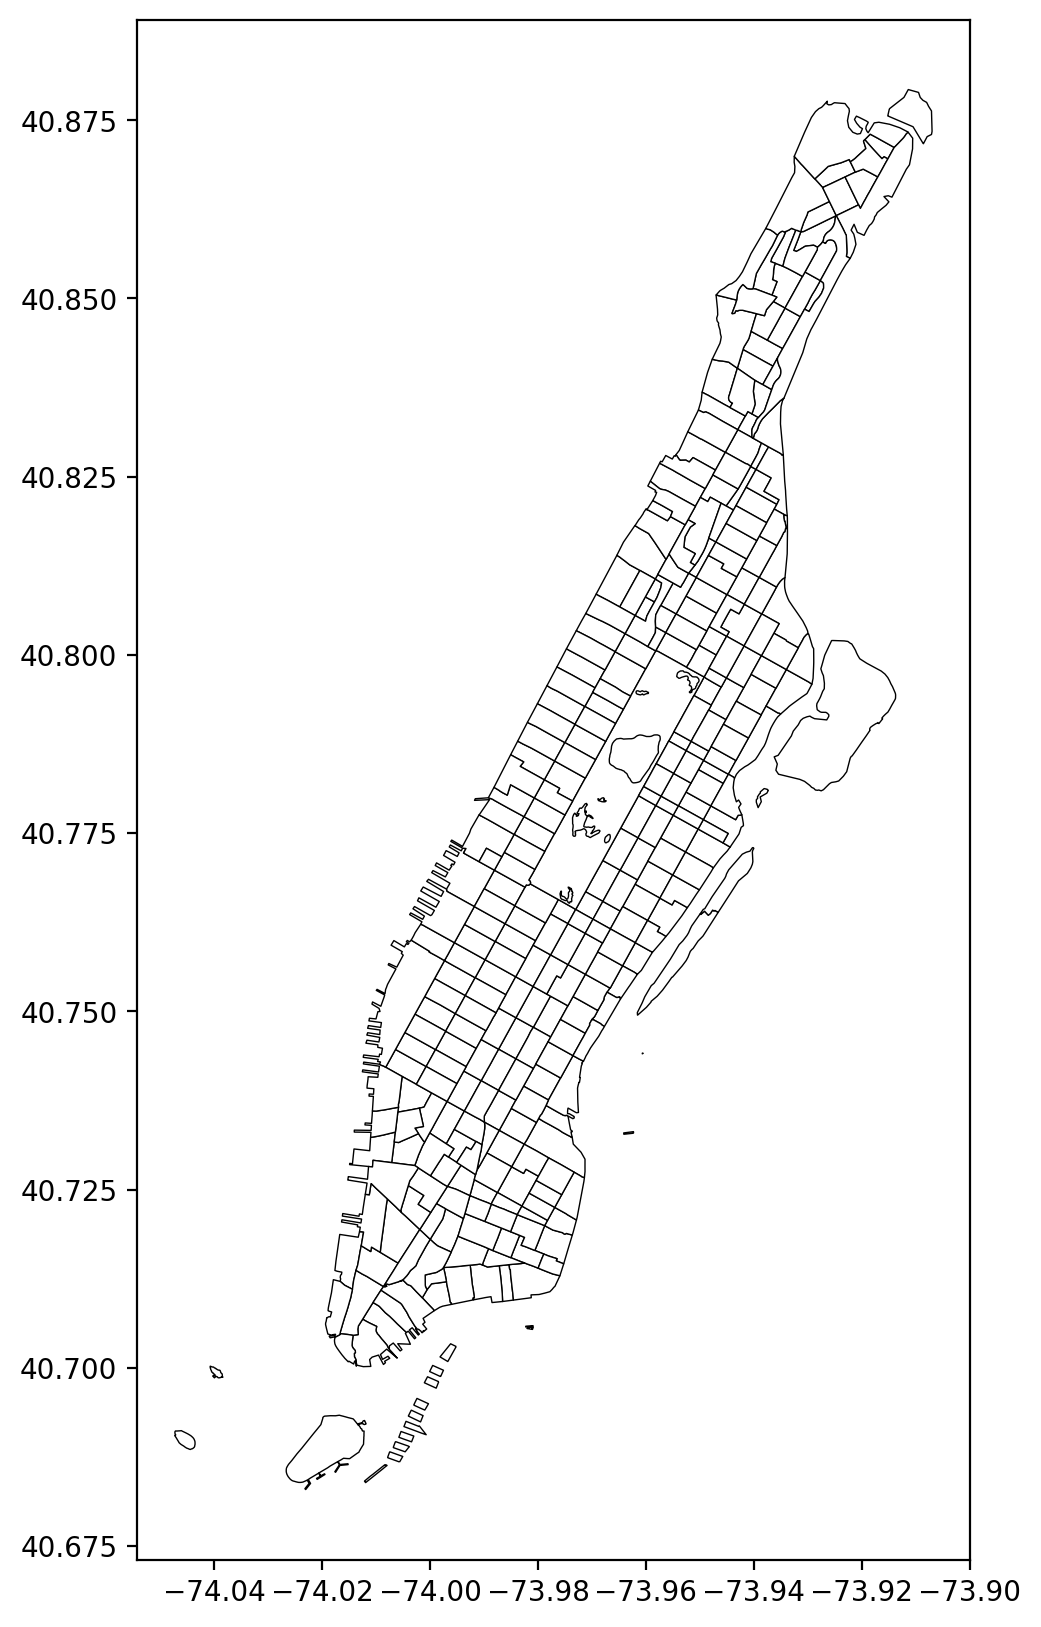

In [ ]:
# Plot the tract boundaries
geo_df.plot(
    figsize=(10, 10),
    color="white",
    edgecolor="black",
    linewidth=0.5,
    zorder=0,
    facecolor="white",
)

In [ ]:
# Interactive visualization, using Folium
geo_df.explore("NAMELSAD",
               cmap='tab20',
               legend=False,
               tiles='cartodbpositron',
               style_kwds=dict(color="black", linewidth=1)
               )

## US Census Tracts and the ACS5 survey: Wealth of demographic data

The US Census runs a yearly survey (the ACS survey) that collects a wide variety of detailed information about each census tract. [For example, consider the information about our own census tract](https://censusreporter.org/profiles/14000US36061005501-census-tract-5501-new-york-ny/): data about population, income, age, educational level, house values, renters vs owners, and many many other data points.

The file below contains the description of all the US Census tracts:

In [ ]:
# @title Helper function that calls the Census API for the ACS5 survey data


def retrieve_census_data_tract(census_attr, friendly_name, state, county, year="2019"):
  '''
  For county, we can specify county="*" to get all the tracts in the state.
  We can also list a comma-separated list to get multiple counties but not all
  For example county = "061,081,047" will retrieve Manhattan, Queens, and Brooklyn

  We can similarly specify a list of states (e.g., state="36,42,34") if we want
  to retrieve more than one state at a time. But we cannot have
  state="*" and county="*" at the same time
  '''

  endpoint = f'https://api.census.gov/data/{year}/acs/acs5'
  params = {
      "get" : f"NAME,{census_attr}",
      "for" : "tract:*", # We ask for all tracts
      "in" : f"state:{state} county:{county}"
  }

  resp = requests.get(endpoint, params = params)
  data = resp.json()
  df = pd.DataFrame(data[1:], columns=data[0])

  # Renaming the census variable code to its "friendly name"
  df = df.rename({census_attr: friendly_name}, axis="columns")
  # We do not need the name of the tract
  df = df.drop("NAME", axis="columns")

  # replace missing value indicator with NaN
  df = df.replace(to_replace=-666666666, value=pd.NA)
  df[friendly_name] = pd.to_numeric(df[friendly_name], errors='coerce')

  # To visualize the variable, we will assign a percentile score to
  # each tract (otherwise outlier values make it hard to differentiate)
  df[friendly_name + "_percentile"] = df[friendly_name].rank(pct=True)

  df = df.filter(['state', 'county', 'tract', friendly_name, friendly_name + "_percentile"])

  return df

In [ ]:
# Example code for retrieving a census variable for the location of interest

census_attr = "B07001_001E"
friendly_name = "Total_Population"

# Get the population of each census tract in Manhattan (STATEFP=36, COUNTYFP=061)
# For county, we can specify county="*" to get all the tracts in the state.
# We can also list a comma-separated list to get multiple counties but not all
# For example county = "061,081,047" will retrieve Manhattan, Queens, and Brooklyn
df = retrieve_census_data_tract(census_attr, friendly_name, state = "36", county = "061")
df

## Exercise

Below, you will find a list of various variables of interest. (You can find the full, exhaustive list of variables in [html](https://api.census.gov/data/2021/acs/acs5/variables.html) and [json](https://api.census.gov/data/2021/acs/acs5/variables.json) formats.

* Pick a variable of choice and retrieve the data for Manhattan.
* Find the FIPS codes for other boroughs/counties of NYC and get the data for these.


In [ ]:
# @title Some useful census variables and their codes

some_useful_census_variables = {
        "B07001_001E": "Total_Population",
        "B07013_002E": "Owner",
        "B07013_003E": "Renter",
        "B07001_017E": "Same_house_1_year_ago",
        "B07013_005E": "Same_house_1_year_ago_owner",
        "B07013_006E": "Same_house_1_year_ago_renter",
        "B19127_001E": "Aggregate_Income",
        "B19126_001E": "Median_Family_Income",
        "B25064_001E": "Median_Gross_Rent",
        "B25103_001E": "Median_Real_Estate_Taxes",
        "B19083_001E": "Gini_Index",

        "B19080_001E": "Household_Income_Lowest_Quintile_Upper_Limit",
        "B19080_002E": "Household_Income_Second_Quintile_Upper_Limit",
        "B19080_003E": "Household_Income_Third_Quintile_Upper_Limit",
        "B19080_004E": "Household_Income_Fourth_Quintile_Upper_Limit",
        "B19080_005E": "Household_Income_Top_5_Percent_Lower_Limit",

        "B13016_002E": "Women_Gave_Birth_Last_Year",
        "B13016_010E": "Women_No_Birth_Last_Year",

        "B25038_015E": "Renter_Moved_in_1979_or_earlier",
        "B25038_014E": "Renter_Moved_in_1980_to_1989",
        "B25038_013E": "Renter_Moved_in_1990_to_1999",
        "B25038_012E": "Renter_Moved_in_2000_to_2009",
        "B25038_011E": "Renter_Moved_in_2010_to_2014",
        "B25038_010E": "Renter_Moved_in_2015_or_later",

        "B25038_008E": "Owner_Moved_in_1979_or_earlier",
        "B25038_007E": "Owner_Moved_in_1980_to_1989",
        "B25038_006E": "Owner_Moved_in_1990_to_1999",
        "B25038_005E": "Owner_Moved_in_2000_to_2009",
        "B25038_004E": "Owner_Moved_in_2010_to_2014",
        "B25038_003E": "Owner_Moved_in_2015_or_later",

        "B11016_002E": "Family_households",
        "B11016_003E": "Family_households_2person",
        "B11016_004E": "Family_households_3person",
        "B11016_005E": "Family_households_4person",
        "B11016_006E": "Family_households_5person",
        "B11016_007E": "Family_households_6person",
        "B11016_008E": "Family_households_7_or_more",

        "B11016_009E": "NonFamily_households",
        "B11016_010E": "NonFamily_households_1person",
        "B11016_011E": "NonFamily_households_2person",
        "B11016_012E": "NonFamily_households_3person",
        "B11016_013E": "NonFamily_households_4person",
        "B11016_014E": "NonFamily_households_5person",
        "B11016_015E": "NonFamily_households_6person",
        "B11016_016E": "NonFamily_households_7_or_more",

        "B01001_001E": "Total_Population_All_Races",
        "B01001A_001E": "Total_Population_White",
        "B01001B_001E": "Total_Population_Black",
        "B01001C_001E": "Total_Population_Native",
        "B01001D_001E": "Total_Population_Asian",
        "B01001E_001E": "Total_Population_PacificIslander",
        "B01001F_001E": "Total_Population_Other",
        "B01001G_001E": "Total_Population_Multiple",
        "B01001H_001E": "Total_Population_White_NonHispanic",
        "B01001I_001E": "Total_Population_Hispanic"
 }


## Visualizing Census Variables on a Map

### Population in Tract

In [ ]:
census_attr = "B07001_001E"
friendly_name = "Total_Population"

# Get the population of each census tract in Manhattan (STATEFP=36, COUNTYFP=061)
df = retrieve_census_data_tract(census_attr, friendly_name, state = "36", county = "061")
df

In [ ]:
# We now join the "geodataframe" (that has the geo boundaries)
aux_df = pd.merge(
    geo_df,
    df,
    left_on=["STATEFP", "COUNTYFP", "TRACTCE"],
    right_on=["state", "county", "tract"],
    how = 'left'
)

In [ ]:
# Plotting the raw population values
# Notice that due to a few outlier values,
# we do not use the full color scheme
ax = aux_df.plot(
    figsize=(6,4),
    column=friendly_name, # "Total_Population" declareb above
    linewidth=0.25,
    edgecolor="Black",
    cmap="Blues", # continuous colormap
    # cmap="coolwarm", # divergent colormap
    # scheme = "Quantiles", k = 5, # We can define buckets instead
    alpha=0.8, legend=True
)
ax.set_title(friendly_name)

pass # do not print the title in the output

In [ ]:
# By using the percentile values instead (which are normalized and uniform)
# the colors associated with each tract are now more informative (at the
# expense of not highlighting the outliers)
ax = aux_df.plot(
    column=friendly_name + "_percentile",
    linewidth=0.25,
    edgecolor="Black",
    figsize=(8,4),
    cmap="coolwarm",
    # scheme = "Quantiles", k = 5, # We can define buckets instead of continuous
    alpha=0.8, legend=True
)
ax.set_title(friendly_name + "_percentile")
pass # do not print the title in the output

In [ ]:
# Interactive map, using the "explore" function
aux_df.explore(
    friendly_name + "_percentile",
    cmap='coolwarm',
    legend=False,
    tiles='cartodbpositron',
    style_kwds=dict(color="black", linewidth=1)
    )

## Exercise

Pick a census variable of interest and create a plot for the Manhattan tracts.

## (Optional) Putting multiple maps on a plot, plus Manhattan neighborhoods

In [ ]:
# Dataset from NYC Open Data: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas/cpf4-rkhq
nyc_geourl = "https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON"
nyc_neighborhoods = gpd.GeoDataFrame.from_file(nyc_geourl)
manhattan = nyc_neighborhoods[nyc_neighborhoods.county_fips == "061"]

In [ ]:
def plot_variable(df, variable_name, percentile, ax):

  if percentile: suffix = "_percentile"
  else:  suffix = ""

    # Plot the variable of interest
  ax = df.plot(
      column=variable_name + suffix,
      linewidth=0.5,
      edgecolor="Black",
      cmap="coolwarm",
      alpha=0.6,
      ax = ax
  )
  ax.set_title(variable_name + suffix)

  # For aesthetics, we plot the NYC neighborhoods on top
  manhattan.plot(
      color="white",
      edgecolor="black",
      linewidth=2,
      zorder=0,
      facecolor="white",
      ax=ax,
  )
  return ax

In [ ]:
census_attr = "B19126_001E"
friendly_name = "Median_Family_Income"
income_df = retrieve_census_data_tract(census_attr, friendly_name, state = "36", county = "061")
income_df = pd.merge(geo_df, income_df, left_on=["STATEFP", "COUNTYFP", "TRACTCE"], right_on=["state", "county", "tract"])

In [ ]:
census_attr = "B19083_001E"
friendly_name = "Gini_Index"
gini_df = retrieve_census_data_tract(census_attr, friendly_name, state = "36", county = "061")
gini_df = pd.merge(geo_df, gini_df, left_on=["STATEFP", "COUNTYFP", "TRACTCE"], right_on=["state", "county", "tract"])

In [ ]:
census_attr = "B07001_001E"
friendly_name = "Total_Population"
population_df = retrieve_census_data_tract(census_attr, friendly_name, state = "36", county = "061")
population_df = pd.merge(geo_df, population_df, left_on=["STATEFP", "COUNTYFP", "TRACTCE"], right_on=["state", "county", "tract"])

# Using the land area of each tract, we can calculate the population density
# to account for the different sizes of the tracts
population_df['Population_Density'] = population_df['Total_Population']/population_df['ALAND']
population_df['Population_Density_percentile'] = population_df['Population_Density'].rank(pct=True)

In [ ]:

# Create a figure, with a 1x4 grid.
# The "ax" is a 1-dimensional array with 4 elements
fig, ax = plt.subplots(nrows=1, ncols=4, figsize =(20,8))

# We now create one plot for each of the 4 "axes" and put the plot in the
# corresponding ax
plot_variable(population_df, "Total_Population", percentile=True, ax = ax[0])
plot_variable(population_df, "Population_Density", percentile=True, ax = ax[1])
plot_variable(income_df, "Median_Family_Income", percentile=True, ax = ax[2])
plot_variable(gini_df, "Gini_Index", percentile=True, ax = ax[3])



In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize =(20,8))
plot_variable(income_df, "Median_Family_Income", percentile=True, ax = ax)

In [ ]:

# Repeat, but with two rows and two columns
# Create a figure, with a 2x2 grid. The "ax" is a 2-dimensional array
fig, ax = plt.subplots(nrows=2, ncols=2, figsize =(10,15))

# We now create one plot for each of the 4 "axes" and put the plot in the
# corresponding ax
plot_variable(population_df, "Total_Population", percentile=False, ax = ax[0][0])
plot_variable(population_df, "Total_Population", percentile=True, ax = ax[0][1])
plot_variable(population_df, "Population_Density", percentile=False, ax = ax[1][0])
plot_variable(population_df, "Population_Density", percentile=True, ax = ax[1][1])

In [ ]:
population_df.explore("Population_Density")

## (Optional) Plot the maps using Folium



Good tutorials at:
* https://www.roelpeters.be/plot-choropleth-map-geopandas-folium/
* https://nbviewer.org/github/python-visualization/folium/blob/master/examples/GeoJSON_and_choropleth.ipynb#Using-choropleth-method

Consider adjusting the `StepColormap` if you want to use more bins than the default 12 ones provided by Folium.

### Simple use of Folium using the `explore` function of geopandas

In [ ]:
income_df.explore("Median_Family_Income_percentile", cmap='coolwarm', legend=False, tiles='cartodbpositron', style_kwds=dict(color="black", linewidth=1))

### More customized use of Folium allowing further customization

In [ ]:
# First we prepare our datasets to be easily joined
income_df['FIPS_code'] = income_df['STATEFP'] + income_df['COUNTYFP'] + income_df['TRACTCE']

# Need to convert our geopandas into a format that the Choropleth function
# of Folium can understand directly. We convert to GeoJSON
geometries = geo_df.filter(['GEOID', 'geometry']).set_index('GEOID').to_json()

# We only keep the columns that we need from the data
income = income_df.filter(['FIPS_code', 'Median_Family_Income', 'Median_Family_Income_percentile'])

In [ ]:
import folium
fmap = folium.Map(location=[40.775, -73.95], zoom_start=12, tiles='cartodbpositron')


# We want more color bins than the default, so we create them here
quantiles = np.linspace(0,1,num=12)
bins = list(income["Median_Family_Income"].quantile(quantiles))

folium.Choropleth(geo_data=geometries,
                data=income,
                name="Median_Family_Income",
                columns=['FIPS_code', 'Median_Family_Income'],
                key_on='feature.id',
                fill_color='RdBu_r', # Red-Blue divergent colormap, reverse order (_r) to put the red for high
                fill_opacity=0.5,
                line_opacity=0.1,
                legend_name='Median_Family_Income',
                nan_fill_color = 'gray',
                nan_fill_opacity = 0.25,
                highlight=True,
                bins=bins
).add_to(fmap)

folium.LayerControl().add_to(fmap)
fmap